In [1]:
import openeo
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import Point, Polygon
import numpy as np
from datetime import datetime
import rasterio
from rasterio.transform import from_origin
from rasterio.transform import Affine
import os

# This is just a demo

In [94]:
data = pd.read_excel('sediment.xlsx')
data = data.dropna(how='all')
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [95]:

data = data.dropna(how='all')
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [96]:
data.columns

Index(['ActivityStartDate', 'ActivityConductingOrganizationText',
       'MonitoringLocationIdentifier', 'latitude', 'longitude',
       'HydrologicEvent', 'CharacteristicName', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'ResultStatusIdentifier', 'geometry'],
      dtype='object')

In [97]:
def create_square_polygon(point, distance_miles):
    """_summary_
    Create a square polygon around the point with the specified distance in miles.
    
    Args:
        point: A Shapely Point object with longitude and latitude.
        distance_miles: Distance from the point to the edges of the square in miles.
    
    Returns a tuple with (min_lon, max_lon, min_lat, max_lat) representing the square.
    
    """
    miles_per_degree_lat = 69.0
    distance_degrees_lat = distance_miles / miles_per_degree_lat
    
    avg_lat = point.y
    miles_per_degree_lon = 69.172 * np.cos(np.radians(avg_lat))
    distance_degrees_lon = distance_miles / miles_per_degree_lon
    
    # Calculate square boundaries
    min_lon = point.x - distance_degrees_lon
    max_lon = point.x + distance_degrees_lon
    min_lat = point.y - distance_degrees_lat
    max_lat = point.y + distance_degrees_lat
    
    # Return the square as a tuple of its boundary coordinates
    return (min_lon, max_lon, min_lat, max_lat)


squares = data['geometry'].apply(lambda x: create_square_polygon(x, 5))
data['square_boundaries'] = squares

In [98]:
data['square_boundaries'][0]

(-84.5876081607477, -84.39395543925228, 41.63703103188406, 41.78195856811595)

In [99]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])

# Now convert to 'YYYY-MM-DD' format
data['ActivityStartDate'] = data['ActivityStartDate'].dt.strftime('%Y-%m-%d')

In [100]:
data['name'] = data['ActivityStartDate'] + '_' + data['MonitoringLocationIdentifier']
data['name'] = data['name'].str.replace('-', '_', regex=False)

In [101]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

Note the NullAuth in the representation of the connection, which indicates that we are not logged in yet.

The canonical way to log in is using the authenticate_oidc() method. This might, depending on your situation, trigger an authentication procedure. Follow the instructions, if any.

In [102]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Note that the connection is now authenticated now through OidcBearerAuth.

With our authenticated connection, we can now start loading a data collection data to build a DataCube, filtered according to specific spatio-temporal constraints:

now give a test for the first object

In [103]:
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])
data['StartOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.start_time
data['EndOfMonth'] = data['ActivityStartDate'].dt.to_period('M').dt.end_time
data['EndOfMonth'] = data['EndOfMonth'].dt.date

In [106]:
i = 0
data['StartOfMonth'][i].strftime('%Y-%m-%d')

'2020-11-01'

the bright clouds ruin the composite image.

## Cloud masking

First we build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability):

In [107]:
for i in range(0, len(data)):

    start_date_iso = data['StartOfMonth'][i].strftime('%Y-%m-%d')
    end_date_iso = data['EndOfMonth'][i].strftime('%Y-%m-%d')
    
    s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=(start_date_iso, end_date_iso),
    spatial_extent={
        "west": data['square_boundaries'][i][0],
        "south": data['square_boundaries'][i][2],
        "east": data['square_boundaries'][i][1],
        "north": data['square_boundaries'][i][3],
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02", "B08", "SCL"],
    max_cloud_cover=50,
)
    scl_band = s2_cube.band("SCL")
    cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)

    cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)
    cube_masked = s2_cube.mask(cloud_mask)
    
    day_of_month = data['ActivityStartDate'][i].day
    number_check = int(day_of_month)
    print(day_of_month)

    if number_check > 20:
        result_cube = cube_masked.max_time()
    elif number_check > 10:
        result_cube = cube_masked.median_time()
    else:
        result_cube = cube_masked.min_time()
    
    result_cube.download("{}.nc".format(data['name'][i]))

9
10
12
17
19
23


In [37]:
ds = xarray.load_dataset("{}.nc".format(data['name'][0]))
# Convert xarray DataSet to a (bands, t, x, y) DataArray
des = ds[["B04", "B03", "B02", "B08"]].to_array(dim="bands")


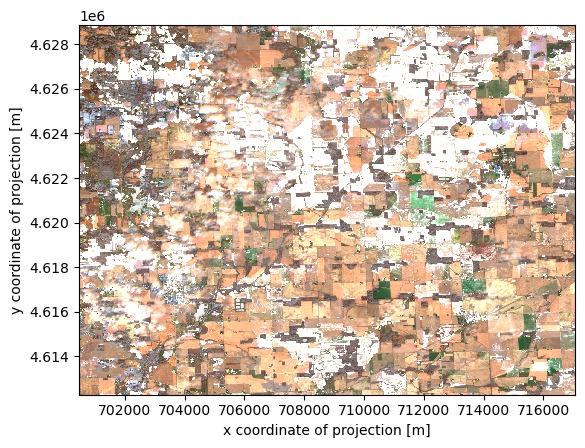

In [39]:
des.plot.imshow(vmin=0, vmax=2000)

In [2]:
name_list = []
entries = os.listdir()
for file in entries:
    if file.endswith(".nc"):
        name_list.append(file)

output_list = [file.replace('.nc', '.tif') for file in name_list]


In [3]:
for i in range(0, len(name_list)):
    data = xarray.load_dataset("{}".format(name_list[i]))
    des = data[["B04", "B03", "B02", "B08"]].to_array(dim="bands")

    x = data.x.values
    y = data.y.values

    pixel_size_x = x[1] - x[0]
    pixel_size_y = y[0] - y[1] 

    transform = Affine(pixel_size_x, 0, x[0],
                   0, -pixel_size_y, y[0])
    
    with rasterio.open(
    '{}'.format(output_list[i]), 
    'w', 
    driver='GTiff', 
    height=des.shape[1], 
    width=des.shape[2], 
    count=len(des.bands), 
    dtype=des.dtype, 
    crs='EPSG:4326', 
    transform=transform
) as dst:
    # Write each band to the file
        for j in range(len(des.bands)):
            # print(des.bands[j])
            dst.write(des.isel(bands=j).values, j + 1)